In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

In [2]:
def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig

In [3]:
def normalize_grid(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [4]:
s_grid_file = open('Насыщенность', 'r')
p_grid_file = open('Пористость', 'r')
d_grid_file = open('Толщины', 'r')

x size: 728
y size: 525


100%|████████████████████████████████████████████████████████████████████████| 63700/63700 [00:00<00:00, 187965.89it/s]


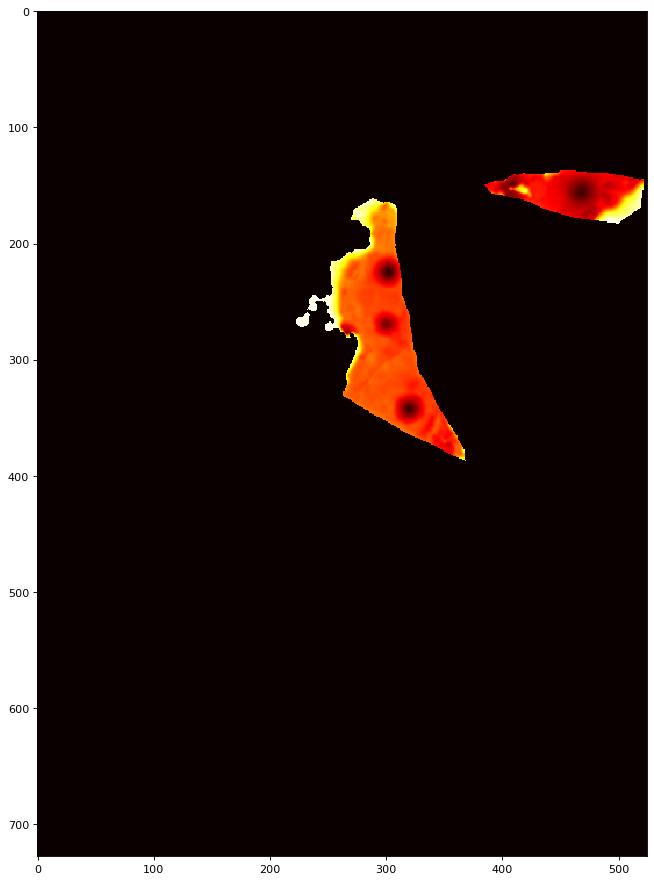

x size: 728
y size: 525


100%|████████████████████████████████████████████████████████████████████████| 63700/63700 [00:00<00:00, 151359.64it/s]


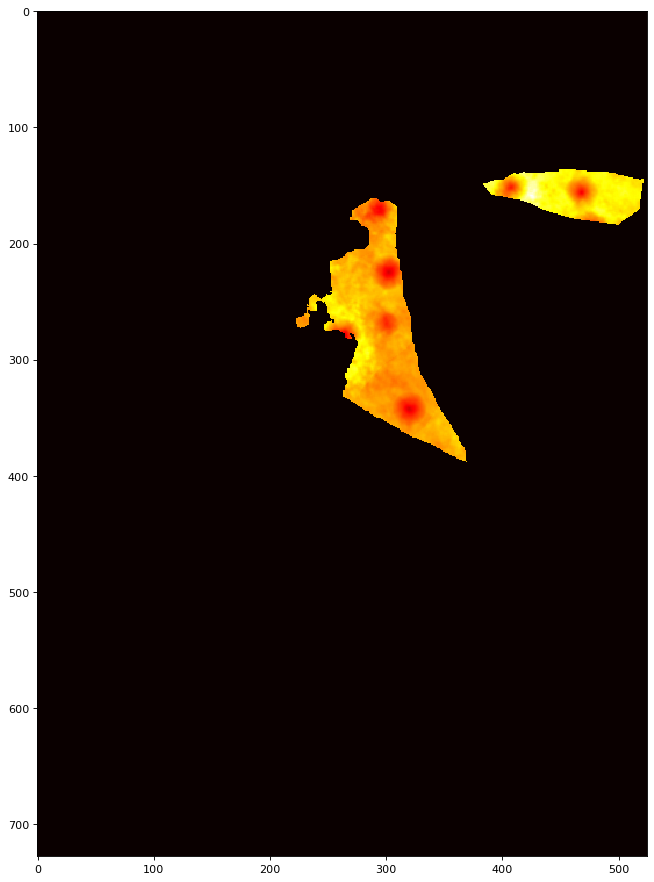

x size: 728
y size: 525


100%|████████████████████████████████████████████████████████████████████████| 63700/63700 [00:00<00:00, 166831.41it/s]


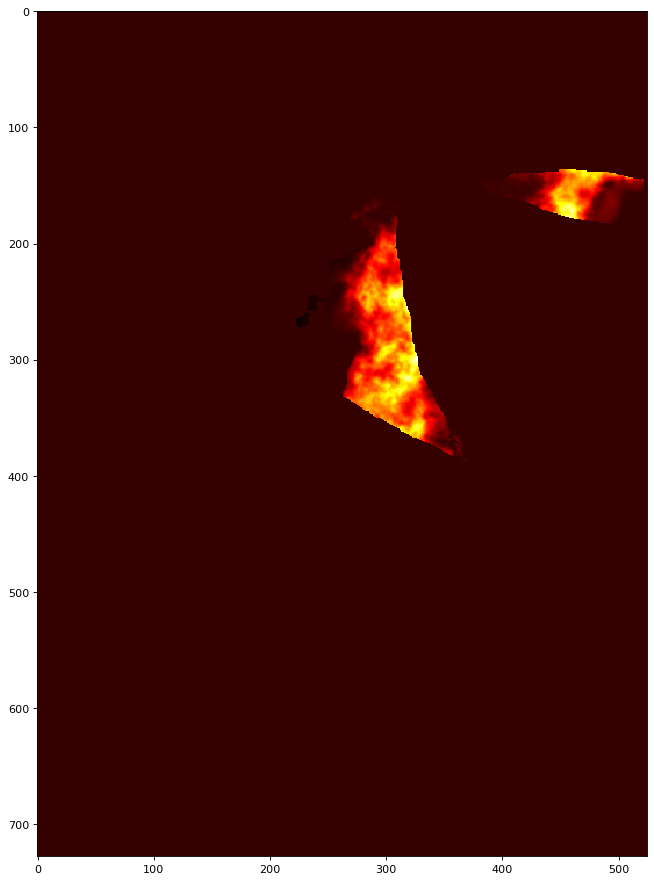

In [5]:
grids = []
for grid_file in [s_grid_file, p_grid_file, d_grid_file]:
    lines = grid_file.readlines()
    for i in range (0, len(lines)):
        lines[i] = lines[i].replace('\n', '')
    
    numX = int(lines[0].split(' ')[1])
    numY = int(lines[2].split(' ')[0])
    b_lines = lines[4:]
    print('x size:', numX)
    print('y size:', numY)
    len(b_lines) * 6 == numX*numY
    
    grid_values = np.zeros((numX, numY)) 
    x_i = 0
    y_i = 0

    for l in tqdm(b_lines):
        values = l.split(' ')
        for val in values:
            if int(float(val)) != 9999900:
                grid_values[x_i][y_i] = float(val)

            y_i += 1
            if y_i == numY:
                y_i = 0
                x_i += 1
    
    grid_values = np.fliplr(grid_values[::-1,::-1])
    figure(figsize=(16, 14), dpi=80)
    plt.imshow(grid_values, cmap='hot', interpolation='none')
    plt.show()
    grids.append(grid_values)

In [6]:
s_grid_values = grids[0]
p_grid_values = grids[1]
d_grid_values = grids[2]

print(s_grid_values.shape == p_grid_values.shape)
print(s_grid_values.shape == d_grid_values.shape)

True
True


In [7]:
# s_grid_values = normalize_grid(s_grid_values)
# p_grid_values = normalize_grid(p_grid_values)
# d_grid_values = normalize_grid(d_grid_values)

In [8]:
np.mean(s_grid_values)

0.2362811325876505

In [9]:
np.mean(p_grid_values)

0.08287306700156986

In [10]:
np.mean(d_grid_values)

0.03151433399005756

In [11]:
r = 5.

In [12]:
x = np.arange(0, numX)
y = np.arange(0, numY)

In [13]:
min_std = np.sum(s_grid_values) + np.sum(p_grid_values) + np.sum(d_grid_values)
well_coords = (0, 0)
s_optimized_grid_values = s_grid_values
p_optimized_grid_values = p_grid_values
d_optimized_grid_values = d_grid_values

for i in tqdm(range(0, len(s_grid_values))):
    for j in range(0, len(s_grid_values[i])):
        if s_grid_values[i][j] == 0.0 and p_grid_values[i][j] == 0.0 and d_grid_values[i][j] == 0.0:
            continue
        
        c_s_grid_values = s_grid_values.copy()
        c_p_grid_values = p_grid_values.copy()
        c_d_grid_values = d_grid_values.copy()
        
        cx = float(j)
        cy = float(i)
        mask = (y[np.newaxis,:]-cy)**2 + (x[:,np.newaxis]-cx)**2 < r**2
        
        sigmoid_rad = []
        for b in c_s_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_s_grid_values[mask] = sigmoid_rad
        c_s_grid_values[j][i] = 0.001
        
        sigmoid_rad = []
        for b in c_p_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_p_grid_values[mask] = sigmoid_rad
        c_p_grid_values[j][i] = 0.001
        
        sigmoid_rad = []
        for b in c_d_grid_values[mask]:
            sigmoid_rad.append(math.atan(b))
        c_d_grid_values[mask] = sigmoid_rad
        c_d_grid_values[j][i] = 0.001
        
        #print(i, j)
        
        plast_sum = np.sum(c_s_grid_values) + np.sum(c_p_grid_values) + np.sum(c_d_grid_values)
        #figure(figsize=(16, 14), dpi=80)
        #plt.imshow(p_optimized_grid_values, cmap='hot', interpolation='none')
        plt.show()
        if min_std > plast_sum:
            s_optimized_grid_values = c_s_grid_values.copy()
            p_optimized_grid_values = c_p_grid_values.copy()
            d_optimized_grid_values = c_d_grid_values.copy()
            well_coords = (i, j)
            min_std = plast_sum

100%|████████████████████████████████████████████████████████████████████████████████| 728/728 [02:11<00:00,  5.52it/s]


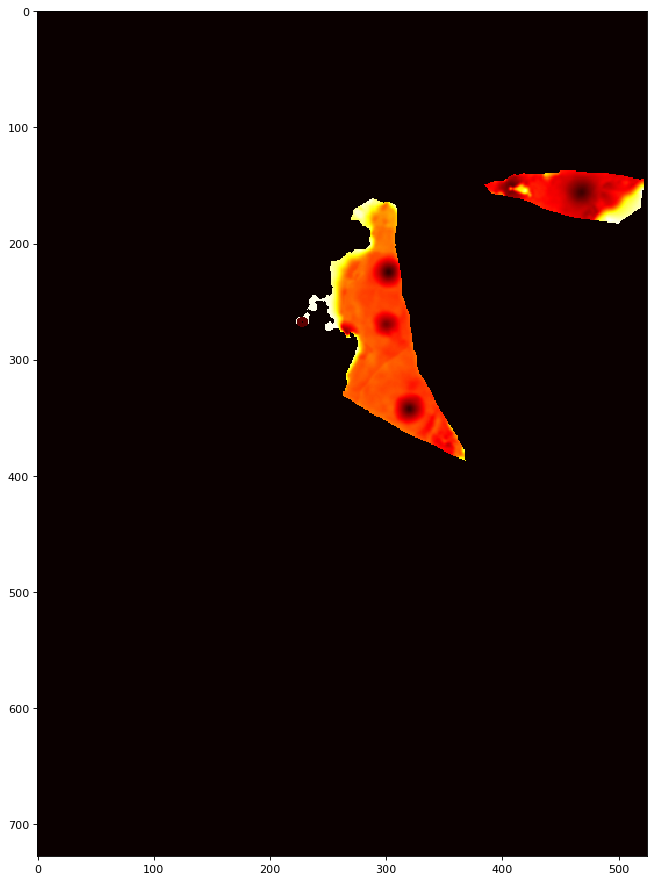

In [14]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(s_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

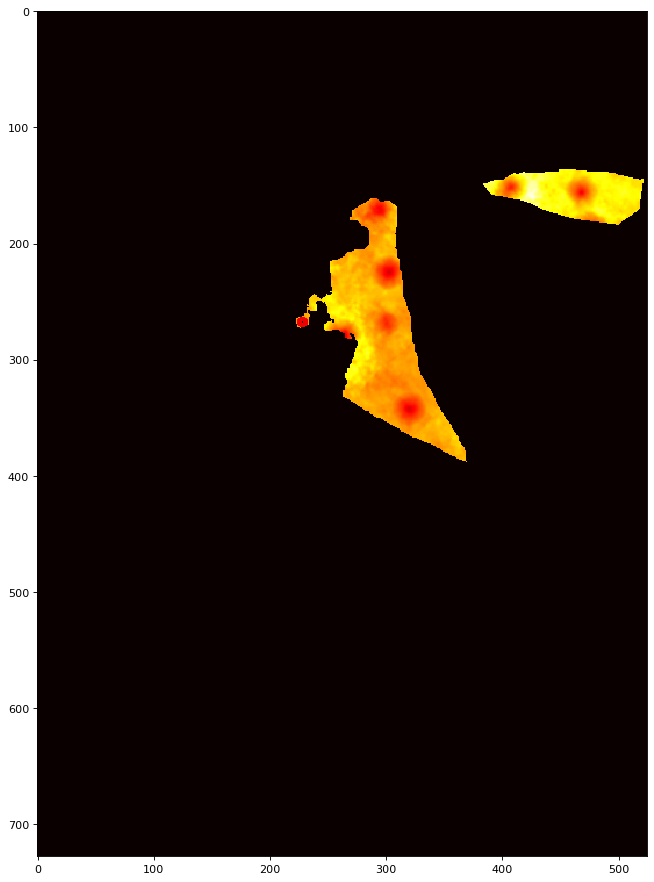

In [15]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(p_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

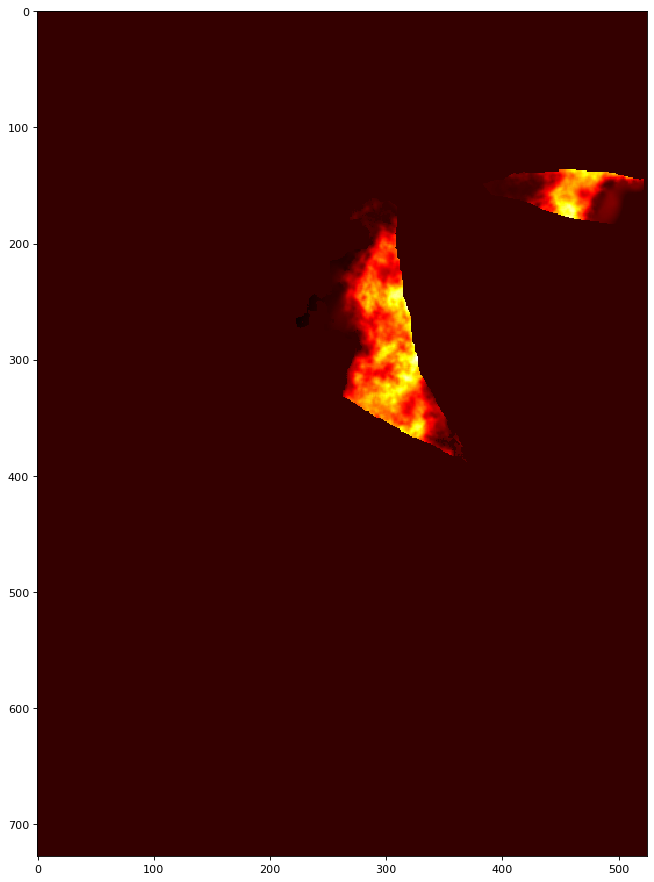

In [16]:
figure(figsize=(16, 14), dpi=80)
plt.imshow(np.float64(d_optimized_grid_values), cmap='hot', interpolation='none')
plt.show()

In [17]:
files = ['Saturation_arctg', 'Porosity_arctg', 'Depth_arctg']
i = 0
for optimized_grid_values in [s_optimized_grid_values, p_optimized_grid_values, d_optimized_grid_values]:
    optimized_grid_values = np.fliplr(optimized_grid_values[::-1,::-1])
    p_lines = []
    p_lines.append(lines[0])
    p_lines.append(lines[1])
    p_lines.append(lines[2])
    p_lines.append(lines[3])

    s = ''
    b = 0
    for v in tqdm(optimized_grid_values):
        for x in v:
            b += 1
            if x == 0.0:
                x = 9999900.000000
            s += str(x)
            if b >= 6:
                b = 0
                p_lines.append(s)
                s = ''
            else:
                s += ' '
    print(len(p_lines) == len(lines))
    
    filename = files[i]
    
    print('Saving', filename, '...')
    with open(filename, 'a') as f:
        for l in p_lines:
            f.write(l+'\n')
            
    i += 1

100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 1507.73it/s]


True
Saving Saturation_arctg ...


100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 1371.47it/s]


True
Saving Porosity_arctg ...


100%|██████████████████████████████████████████████████████████████████████████████| 728/728 [00:00<00:00, 1391.74it/s]


True
Saving Depth_arctg ...
